# Homework 3

Expand upon our understanding of image registration by following the photomosaicking work in the Pizarro2003joe paper

## Part 1

Modify the registration module from the previous homework to allow for a robust feature matching across two images. <br>
Normalize the images before matching them <br>
Use the Levenberg Marquadt algorithm for computing the homography on the inlier set that we obtain after feature matching with any feature/descriptor in combination with outlier rejection via RANSAC<br><br>
Run the registration code to match the 6 images in a loop and the images that are non sequential and might have smaller overlap

In [33]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os

In [34]:
# Save images in a list
imgs = []
dir_name = 'Part1_6Images/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )

for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))

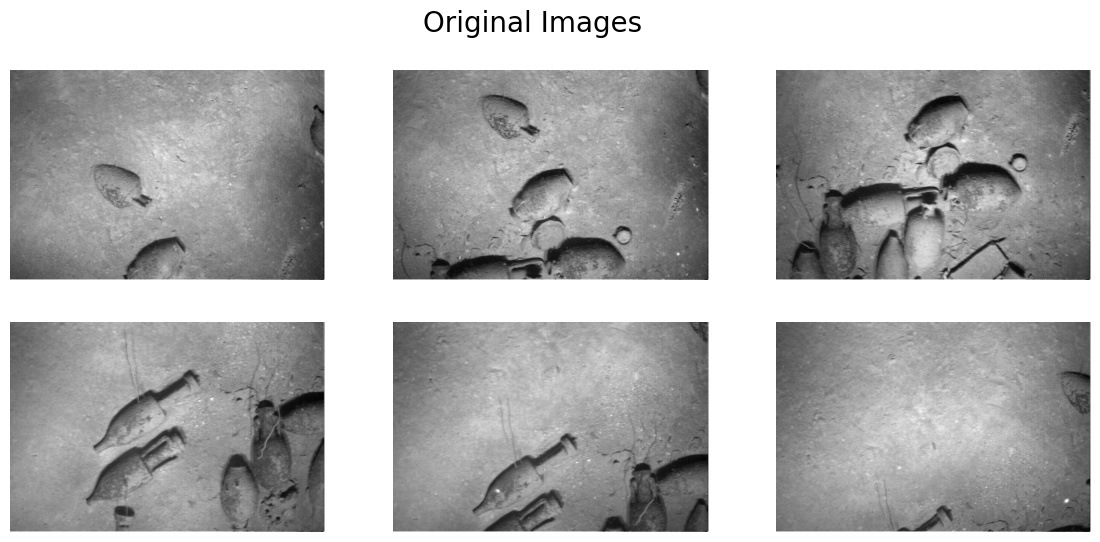

In [35]:
def show_images(num_rows, num_columns, imgs, title=" ", isGrayscale=False):
    f, axs = plt.subplots(num_rows, num_columns,figsize=(14,6))
    for i in range(num_rows):
        for j in range(num_columns):
            img_num = i*num_columns + j
            axs[i,j].imshow(imgs[img_num], cmap='gray' if isGrayscale else 'viridis')
            axs[i,j].axis('off')

    f.suptitle(title, fontsize=20)


show_images(2, 3, imgs, "Original Images")

### Image Preprocessing: Normalization and Grayscale + Contrast Limiting Adaptive Histogram Equalization (CLAHE)

In [36]:
# Normalize Grayscaled Images for better contrast:
def normalize_images(imgs):
    imgs_norm = []
    for img in imgs:
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        imgs_norm.append(img_norm)
    return imgs_norm

def grayscale_images(imgs):
    imgs_gray = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE to grayscale images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        imgs_gray.append(clahe.apply(gr))
    return imgs_gray

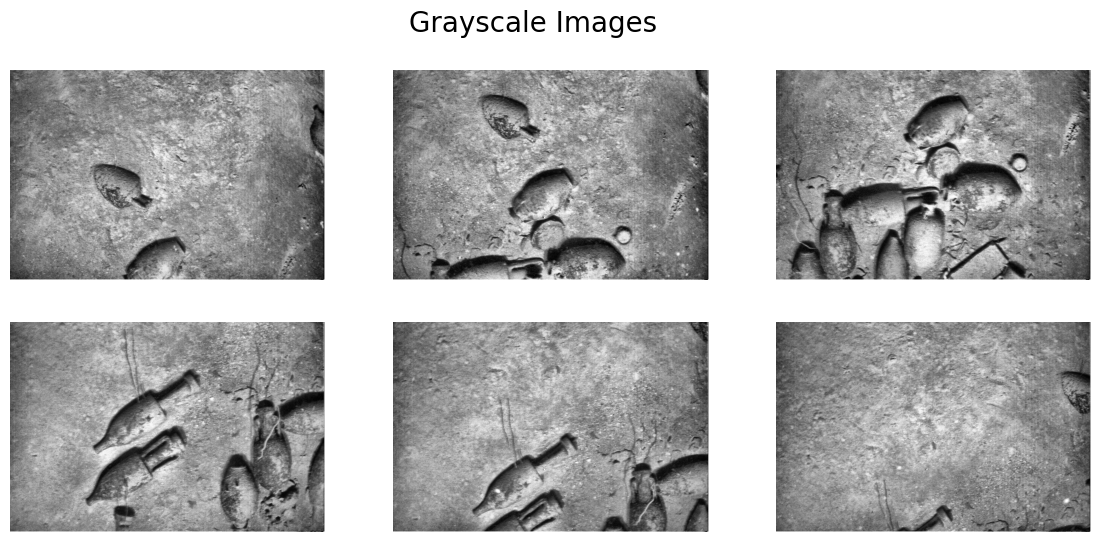

In [37]:
imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)
show_images(2, 3, imgs_gray, "Grayscale Images", True)

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

In [38]:
def find_features(sift_object, imgs_gray):
    kp = []
    des = []
    imgs_sift = []
    for img in imgs_gray:
        k, d = sift_object.detectAndCompute(img,None)
        img_sift = cv2.drawKeypoints(img, k, img, color=[255,255,0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imgs_sift.append(img_sift)
        kp.append(np.array(k))
        des.append(np.array(d))
    return kp, des, imgs_sift

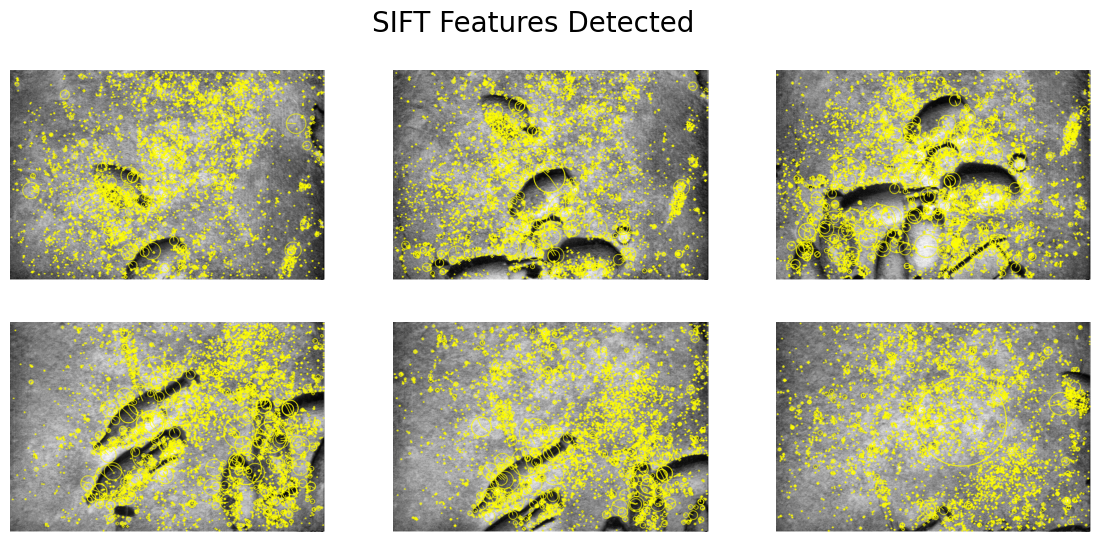

In [39]:
# Create SIFT Object and save keypoints, descriptors, and sift-labeled images
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)
kp, des, imgs_sift = find_features(sift, imgs_gray)
show_images(2, 3, imgs_sift, "SIFT Features Detected")

In [40]:
def get_matches(kp1, des1, kp2, des2):
    # FLANN parameters https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann_match = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    good = []

    # ratio test as per Lowe's paper
    for m,n in flann_match:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.array([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.array([kp2[m.trainIdx].pt for m in good])

    return (src_pts, dst_pts)

def get_all_matches(kp, des):
    matches = []
    if len(kp) == 6:
        last_img_match = 0
    elif len(kp) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")
        
    for i in range(len(kp)):
        ii = i+1 if i < len(kp)-1 else last_img_match
        matches.append(get_matches(kp[i], des[i], kp[ii], des[ii]))
        print("Image: ", i, ", ", ii, " Matches: ", len(matches[i][0]))

    return matches

Get Matches. If I run this multiple times, I get different matches and results that drastically degrade the final stitch

In [41]:
matches = get_all_matches(kp, des)

Image:  0 ,  1  Matches:  550
Image:  1 ,  2  Matches:  483
Image:  2 ,  3  Matches:  52
Image:  3 ,  4  Matches:  569
Image:  4 ,  5  Matches:  391
Image:  5 ,  0  Matches:  47


With matches for each image pair, perform RANSAC on the match points to get the inliers.

In [42]:
# Following procedure from Zernike demo
def ransac(kp, matches, kp_match):
    masks = []
    inliers = []

    i = 0

    for match in kp_match:
        F, mask = cv2.findFundamentalMat(match[0], match[1],
                                            method=cv2.FM_RANSAC,       
                                            ransacReprojThreshold=1.0,
                                            confidence=0.9999)
        masks.append(mask)

        ii = i+1 if i < 5 else 0
        kp0_match_inliers = [kp[i][mat.queryIdx] for mat, msk in zip(matches[i], mask[i]) if msk]
        kp1_match_inliers = [kp[ii][mat.trainIdx] for mat, msk in zip(matches[i], mask[i]) if msk]

        inliers.append((kp0_match_inliers, kp1_match_inliers))
        i+=1

    return inliers, masks

In [43]:
inliers, masks = ransac(kp, matches, kp_matches)

NameError: name 'kp_matches' is not defined

### Compute Homography using Levenberg Marquadt

In [44]:
def get_homography(kp_match_inliers):
    h = []
    pts_left_src = []
    pts_right_dst = []
    mask = []

    # if inliers were not already given to the homography function, get points and do RANSAC
    for kp_match in kp_match_inliers:
        pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
        pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))

    # this is only for the last run
    for i in range(len(pts_left_src)):
        h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,3.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask, (pts_left_src, pts_right_dst)

### Show Matches between images

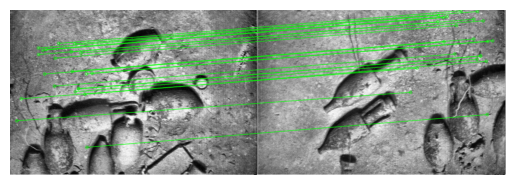

(<matplotlib.image.AxesImage at 0x14f796be380>, None)

In [45]:
kp1 = kp[2]
kp2 = kp[3]
des1 = des[2]
des2 = des[3]
img1 = imgs_gray[2]
img2 = imgs_gray[3]

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

flann_match = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
good = []

# ratio test as per Lowe's paper
for m,n in flann_match:
    if m.distance < 0.7*n.distance:
        good.append(m)

src_pts = np.array([kp1[m.queryIdx].pt for m in good])
dst_pts = np.array([kp2[m.trainIdx].pt for m in good])

h, mask, _ = get_homography([(src_pts, dst_pts)])

draw_params = dict(
    matchColor = (0,255,0), # draw matches in green color
    singlePointColor = None,
    matchesMask = mask[0].ravel().tolist(), # draw only inliers
    flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.axis('off')
plt.imshow(img3, 'gray'),plt.show()

Code from previous homework to stitch two images

In [46]:
def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = cv2.getPerspectiveTransform(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape[:2], img_dst.shape[:2])

    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    # Blend images together
    black = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    mask_dst = cv2.inRange(dst_transformed, np.array([0,0,0]), np.array([0,0,0]))
    mask_src = cv2.inRange(src_warped, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_dst)
    src_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(src_warped, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(dst_transformed, black, mask=overlap_region), 0.5, 0.0)

    # Combine all components of the image together
    img_stitched = dst_fringe + src_fringe + img_overlap_blend

    return img_stitched, offset

SIFT Hyperparameter Tuning: https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html

[[ 1.00681876e+00  5.34468519e-02 -2.83286211e+01]
 [-6.49752466e-02  1.12367723e+00  2.77404392e+02]
 [-4.48453230e-05  2.27775764e-04  1.00667922e+00]]
[[ 7.19118930e-01  1.60067827e-02 -2.28167127e+02]
 [-1.12816781e-01  9.26210645e-01  3.13252523e+02]
 [-4.69852034e-04  2.66692361e-04  1.03366857e+00]]
[[ 6.03373259e-01  3.39357149e-02  6.56407920e+00]
 [-5.24475133e-02  8.74566082e-01  1.87630644e+02]
 [-4.38805758e-04  1.35399458e-04  9.84387558e-01]]
[[ 5.84938283e-01 -3.73906287e-03  1.71375812e+01]
 [ 2.49540563e-02  8.48953018e-01  4.29118082e+01]
 [-4.23977599e-04  9.41874663e-06  9.57350870e-01]]


(-0.5, 833.5, 696.5, -0.5)

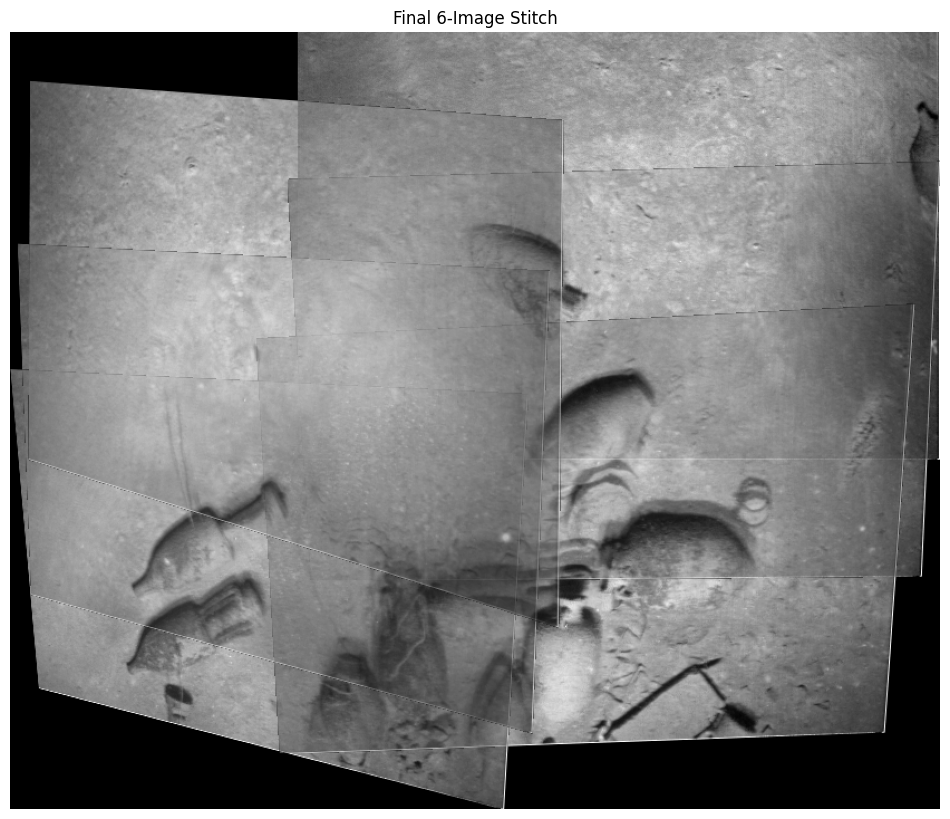

In [47]:
h, mask, _ = get_homography(matches)

t = [0,0]
#mosaicImgs = []
for i in range(len(h)-1):
    #print(t)
    #print(h[i])
    h[i][0][2] += t[0]
    h[i][1][2] += t[1]
    if i != 0:
        h[i] = np.dot(h[i],h[i-1])
        print(h[i])
    if i == 0:
        mosaicImg, t = stitch_images(imgs_norm[i],imgs_norm[i+1],h[i])
        

    elif i > 0 and i < 5:
        mosaicImg, t = stitch_images(mosaicImg,imgs_norm[i+1],h[i])
        
    else:
        mosaicImg, t = stitch_images(mosaicImg,imgs_norm[0],h[i])
    
    #mosaicImgPrev = mosaicImg
    #t = tNew
plt.figure(figsize = (12,12))
plt.imshow(mosaicImg)
plt.title("Final 6-Image Stitch")
plt.axis('off')

### Matching Non-Sequential Images
Use the image pairs: 1-6, 2-5, 2-4, 3-5, 1-5, 2-6. 

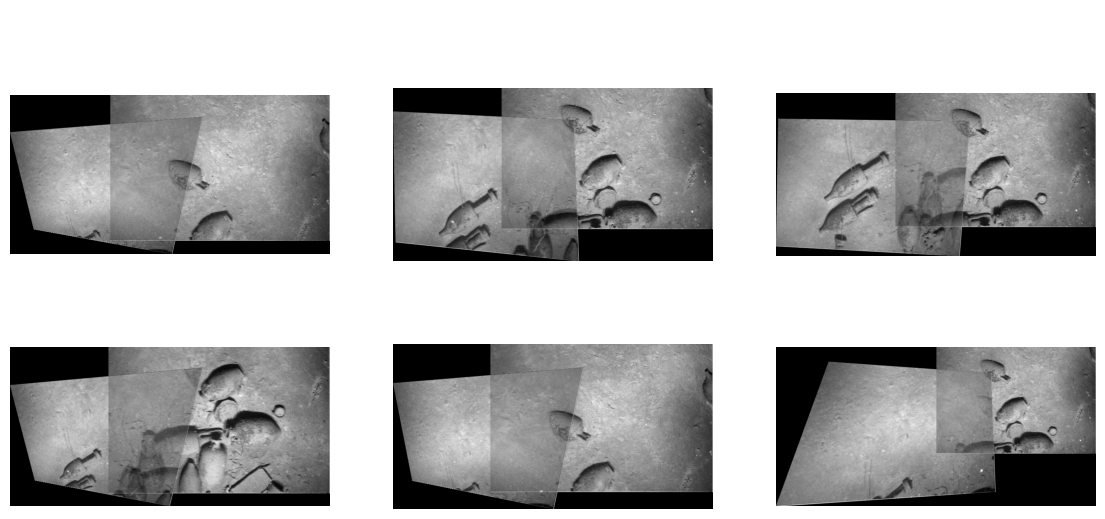

In [48]:
imgs_to_match = [(0, 5), (1, 4), (1, 3), (2, 4), (0, 5), (1, 5)]

myNewImgs = []

for i in range(len(imgs_to_match)):
    matches_nonseq = [get_matches(kp[0], des[0], kp[5], des[5])]
    h_nonseq, mask, _ = get_homography(matches_nonseq)
    nonseq_stitch, t = stitch_images(imgs_norm[imgs_to_match[i][0]],imgs_norm[imgs_to_match[i][1]],h_nonseq[0])

    myNewImgs.append(nonseq_stitch)

show_images(2,3, myNewImgs)